# Classification des séries temporelles de conductances stomatique (gsw) selon leur traitement hydrique avec un modèle de deep neural network


On commence par importer l'ensemble des librairies et méthodes nécessaires.

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import f1_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from collections import Counter
from imblearn.over_sampling import SMOTE

from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential

On télécharge le fichier de données.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Data_gsw_4.csv to Data_gsw_4 (1).csv


In [ ]:
fichier_csv = "fake_path\Data_gsw_4.csv"

On ouvre et on visualise le jeu de données.

In [ ]:
data_gsw = pd.read_csv(fichier_csv, index_col='Unnamed: 0')
data_gsw.head()

,tree,gsw1,gsw2,gsw3,gsw4,gsw5,gsw6,gsw7,gsw8,gsw9,gsw10,gsw11,gsw12,treatment,specie,water_stress,heat_stress
1,PT_WW_1_1,0.3316,NaN,NaN,NaN,0.6592,NaN,NaN,0.5178,NaN,NaN,NaN,0.4540,WW_25,PT,WW,25
2,CE_D_2_1,0.0409,NaN,NaN,NaN,0.0876,NaN,NaN,0.1379,NaN,NaN,NaN,0.1149,WW_25,CE,WW,25
3,TA_D_3_1,0.0205,NaN,NaN,NaN,0.0855,NaN,NaN,0.0445,NaN,NaN,NaN,0.1186,WW_25,TA,WW,25
4,PE_WW_4_1,0.0491,NaN,NaN,NaN,0.0195,NaN,NaN,0.0230,NaN,NaN,NaN,0.0001,WW_25,PE,WW,25
5,SE_WW_5_1,0.0969,NaN,NaN,NaN,0.1701,NaN,NaN,0.2207,NaN,NaN,NaN,0.1748,WW_25,SE,WW,25


On transforme la colonne correspondant au traitement hydrique : WW ou D, en deux colonnes binaires D (qui prend les instances 0 ou 1) et WW (qui prend les instances 0 ou 1).

In [ ]:
data_gsw["dummy"] = 1
data_gsw_wide = data_gsw.pivot(index=data_gsw.iloc[:, np.r_[0:13, 14, 16]],
                                                             columns=["water_stress"], values= "dummy").reset_index()
data_gsw_wide = data_gsw_wide.fillna(0)
data_gsw_wide.head()

water_stress,tree,gsw1,gsw2,gsw3,gsw4,gsw5,gsw6,gsw7,gsw8,gsw9,gsw10,gsw11,gsw12,specie,heat_stress,D,WW
0,CE_D_14_1,0.035600,0.0257,0.0000,0.0642,0.0000,0.0388,0.000000,0.0000,0.0000,0.000,0.0,0.0,CE,25,1.0,0.0
1,CE_D_14_1,0.039100,0.0648,0.0000,0.0000,0.0000,0.0000,0.028136,0.0000,0.0078,0.000,0.0,0.0,CE,25,1.0,0.0
2,CE_D_14_1,0.044100,0.0000,0.0942,0.0000,0.0462,0.0000,0.000000,0.0000,0.0000,0.045,0.0,0.0,CE,25,1.0,0.0
3,CE_D_14_1,0.054126,0.0000,0.0000,0.0126,0.0000,0.0322,0.000000,0.0228,0.0000,0.000,0.0,0.0,CE,25,1.0,0.0
4,CE_D_14_1,0.057600,0.1090,0.1441,0.0000,0.0000,0.1320,0.000000,0.0000,0.0000,0.000,0.0,0.0,CE,25,1.0,0.0


On sélectionne les colonnes en entrée on garde seulement l'information des séries temporelles. On normalise les séries temporelles. On définit ensuite la colonne binaire D comme la sortie de l'algorithme. On sous échantillone les valeurs test (20%) par rapport aux valeurs d'entrainement.

In [ ]:
scaler = StandardScaler()
X = data_gsw_wide.iloc[:, np.r_[1:13]]
X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)

y = data_gsw_wide.iloc[:, np.r_[15]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

On calcule le déséquilibre des classes

In [ ]:
y_train = y_train.values.ravel()
counter = Counter(y_train)
counter

Counter({0.0: 811, 1.0: 341})

On résout le déséquilibre en enrichissant la classes minoritaire du jeu de données par la méthode SMOTE.

In [ ]:
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

On calcule à nouveau le déséquilibre de la classe de sortie.

In [ ]:
counter = Counter(y_train)
counter

Counter({0.0: 811, 1.0: 811})

On formate les entrées pour qu'elles soient compatibles avec la couche LSTM du réseau de neurones.

In [ ]:
X_train_reshaped = np.expand_dims(X_train, axis=1)
X_test_reshaped = np.expand_dims(X_test, axis=1)

### Réseau de neurones

On définit l'architecture du modèle :

In [ ]:
model = Sequential([
    LSTM(16, input_shape=(1,12), return_sequences=True),
    Dropout(0.2),
    LSTM(16),
    Dropout(0.2),
    Dense(24, activation='relu'),
    Dense(12, activation='relu'),
    Dense(4, activation='relu'),
    Dense(1, activation='sigmoid')
])

On visualise le nombre et le type de paramètres du modèle que l'on vient de construire.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 16)             1856      
                                                                 
 dropout (Dropout)           (None, 1, 16)             0         
                                                                 
 lstm_1 (LSTM)               (None, 16)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 25)                425       
                                                                 
 dense_1 (Dense)             (None, 10)                260       
                                                                 
 dense_2 (Dense)             (None, 5)                 5

On crée une fonction qui va arrêter l'apprentissage quand la fonction de cout évaluer sur les données de validations cesse de diminuer, on enregistre alors le modèle le plus pertinent. Cette custom sert à ne pas arrêter l'entrainement durant les 10 premières périodes.

In [ ]:
class CustomEarlyStopping(Callback):
    def __init__(self, patience=0, start_from_epoch=0):
        super(CustomEarlyStopping, self).__init__()
        self.patience = patience
        self.wait = 0
        self.stopped_epoch = 0
        self.start_from_epoch = start_from_epoch
        self.best_weights = None

    def on_train_begin(self, logs=None):
        self.wait = 0
        self.stopped_epoch = 0
        self.best = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get('val_loss')
        if epoch >= self.start_from_epoch:
            if current is None:
                warnings.warn('Early stopping requires validation loss to be available!', RuntimeWarning)

            if np.less(current, self.best):
                self.best = current
                self.wait = 0
                self.best_weights = self.model.get_weights()
            else:
                self.wait += 1
                if self.wait >= self.patience:
                    self.stopped_epoch = epoch
                    self.model.stop_training = True
                    self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print(f'Restoring model weights from the end of the best epoch: {self.stopped_epoch - self.wait + 1}')


In [ ]:
callbacks = [
    CustomEarlyStopping(patience=10, start_from_epoch=10),
    tf.keras.callbacks.ModelCheckpoint(filepath='best_current_model_LSTM_gsw4.h5',
                                               save_best_only=True,
                                               save_weights_only=False,
                                               monitor = 'val_loss',
                                               save_freq='epoch')]

On compile le modèle en définissant la fonction de cout : binary_crossentropy, la méthode de descente du gradient : adam (pas par défaut 0.001), et la métrique d'évaluation : accuracy.

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

On entraine le modèle sur les données, pendant un temps maximum de 200 époques et avec une taille de batch = 32.

In [ ]:
history = model.fit(X_train_reshaped, y_train, epochs=200, batch_size=32, validation_split=0.2, callbacks=callbacks)

Epoch 1/200
41/41 [==============================] - 7s 40ms/step - loss: 0.6862 - accuracy: 0.6191 - val_loss: 0.7236 - val_accuracy: 0.0000e+00
Epoch 2/200
16/41 [==========>...................] - ETA: 0s - loss: 0.6699 - accuracy: 0.6797

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 0s 11ms/step - loss: 0.6620 - accuracy: 0.7032 - val_loss: 0.6792 - val_accuracy: 0.6431
Epoch 3/200
41/41 [==============================] - 0s 11ms/step - loss: 0.6069 - accuracy: 0.7371 - val_loss: 0.6141 - val_accuracy: 0.7354
Epoch 4/200
41/41 [==============================] - 0s 10ms/step - loss: 0.5389 - accuracy: 0.7579 - val_loss: 0.6520 - val_accuracy: 0.6892
Epoch 5/200
41/41 [==============================] - 0s 10ms/step - loss: 0.4979 - accuracy: 0.7571 - val_loss: 0.6475 - val_accuracy: 0.7077
Epoch 6/200
41/41 [==============================] - 0s 12ms/step - loss: 0.4789 - accuracy: 0.7672 - val_loss: 0.5920 - val_accuracy: 0.7692
Epoch 7/200
41/41 [==============================] - 0s 11ms/step - loss: 0.4703 - accuracy: 0.7672 - val_loss: 0.5077 - val_accuracy: 0.8215
Epoch 8/200
41/41 [==============================] - 0s 7ms/step - loss: 0.4607 - accuracy: 0.7733 - val_loss: 0.5865 - val_accuracy: 0.7785
Epoch 9/200
41/41 [

On représente l'évolution de la fonction de cout durant l'entrainement.

Text(0, 0.5, '')

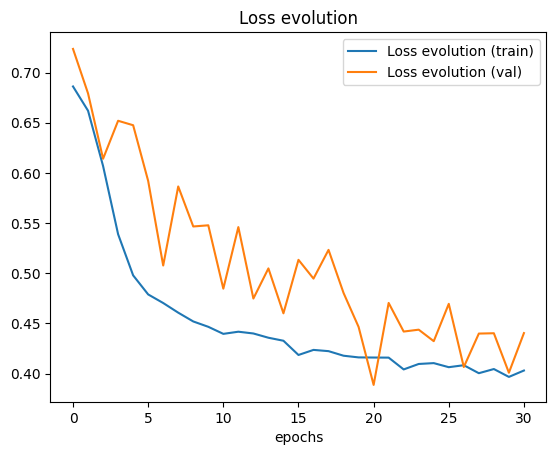

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss evolution')
plt.legend(['Loss evolution (train)','Loss evolution (val)'])
plt.xlabel('epochs')
plt.ylabel('')

On représente l'évolution de la métrique d'évaluation du modèle pendant l'entrainement.

Text(0, 0.5, 'accuracy')

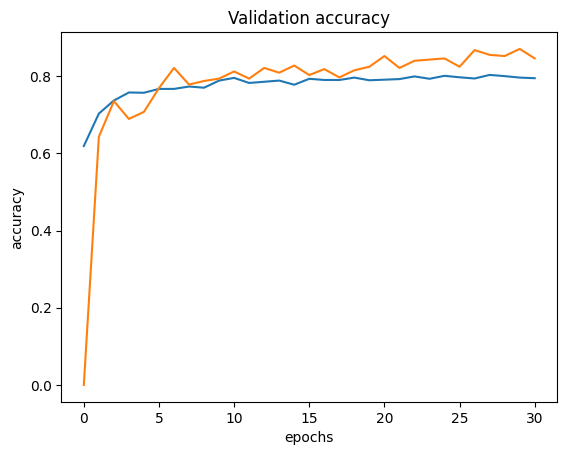

In [ ]:
### Affichage des évolutions de l'accuracy (validation)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')

On récupère le meilleur modèle enregistré.

In [ ]:
model = tf.keras.models.load_model("best_current_model_LSTM_gsw4.h5")

On applique le modèle au jeu de données test et on évalue ses performances avec la métrique f1 weighted.

In [ ]:
prediction = model.predict(X_test_reshaped)
classes_predites=np.where(prediction<0.5, 0, 1)
f1_score(y_test, classes_predites, average="weighted")


9/9 [==============================] - 1s 4ms/step


0.7905721618357489

On évalue les performances du modèle sur les données tests à partir des métriques fonction de cout et accuracy avec lesquelles il est entrainé.

In [ ]:
model.evaluate(X_test_reshaped, y_test)

9/9 [==============================] - 1s 4ms/step - loss: 0.4040 - accuracy: 0.7847


[0.404016375541687, 0.7847222089767456]

On représente enfin la matrice dite de confusion qui permet de classer les visualiser les données mal classées, faux positifs et faux négatifs.

[[153  44]
 [ 18  73]]


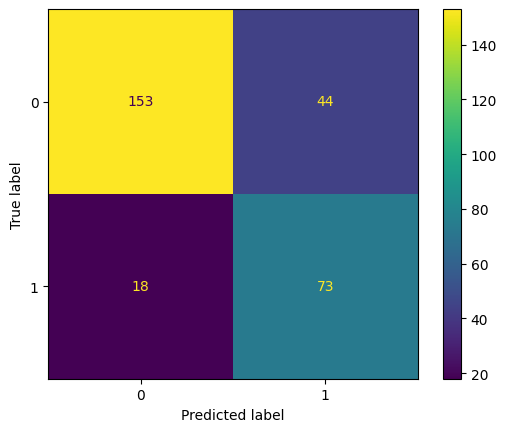

In [ ]:
cm = confusion_matrix(y_test, classes_predites)
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
